# Edge Detection
In this exercise we will create a simple edge detector.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
from scipy import ndimage

## Some convenience functions.

In [2]:
def convolve_with_two(image, kernel1, kernel2):
    """Apply two filters, one after the other."""
    image = ndimage.convolve(image, kernel1)
    image = ndimage.convolve(image, kernel2)   
    return image

def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, imsize=4, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imsize, n_rows * imsize),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

In [3]:
# From Question 2: Image Derivatives
def gauss_derivs(image, sigma):
    ### BEGIN SOLUTION
    kernel_radius = int(3.0 * sigma)
    x = np.arange(-kernel_radius, kernel_radius + 1)[np.newaxis]
    
    # Compute 1D Gaussian kernel 
    gaussderiv_kernel1d = -1 / np.sqrt(2 * np.pi) / sigma**3 * x * np.exp(-x**2.0 / 2 / sigma**2)
    # Compute 1D Derivative-of-Gaussian kernel
    gauss_kernel1d = 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-x**2 / 2 / sigma**2)
    
    image_dx = convolve_with_two(image, gaussderiv_kernel1d, gauss_kernel1d.T)
    image_dy = convolve_with_two(image, gauss_kernel1d, gaussderiv_kernel1d.T)
    ### END SOLUTION
    return image_dx, image_dy

def image_gradients_polar(image, sigma):
    ### BEGIN SOLUTION
    dx, dy = gauss_derivs(image, sigma)
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx)  # between -pi and +pi
    ### END SOLUTION
    return magnitude, direction

## Part a
Write a function ``get_edges`` that returns a binary image ``edge`` from an input image where the color of each pixel $p$ is selected as follows (for a given threshold ``theta``):
\begin{eqnarray}
    p &=&
    \begin{cases}
        1, &\text{ if }\left|\operatorname{grad}(\mathtt{img})\right|(p) \geq \theta\\
        0, &\text{ else}
    \end{cases}
\end{eqnarray}

In [4]:
def get_edges(image, sigma, theta):
    ### BEGIN SOLUTION
    magnitude, _ = image_gradients_polar(image, sigma)
    return magnitude >= theta
    ### END SOLUTION

Experiment with the function ``get_edges`` on the example images.
Try to get good edge images for different values of ``sigma``.
What difficulties do you observe?
(Note: it may pay off to look at the magnitude of the image gradient in order to get a feeling for suitable values of ``theta``).

<IPython.core.display.Javascript object>


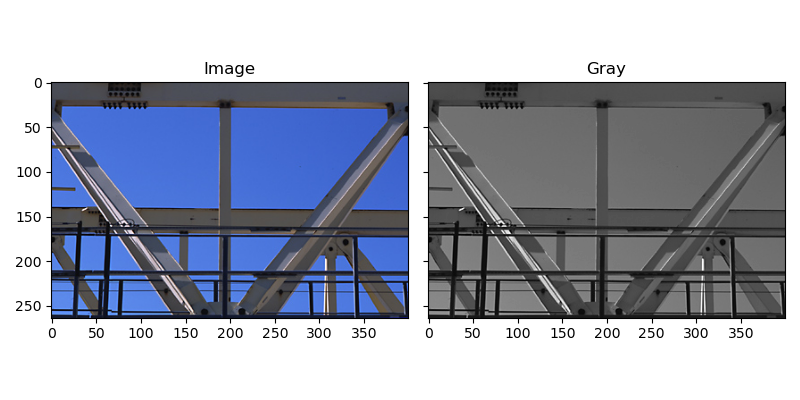

In [5]:
color_im = imageio.imread('gantrycrane.png')
gray_im = cv2.cvtColor(color_im, cv2.COLOR_RGB2GRAY).astype(np.float32)
plot_multiple([color_im,gray_im], ['Image','Gray'])

<IPython.core.display.Javascript object>


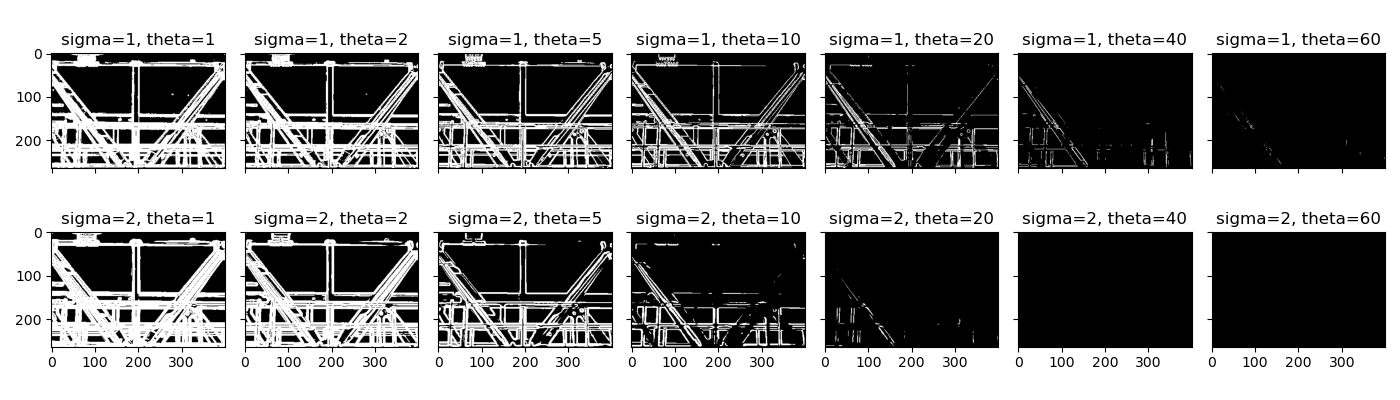

In [6]:
sigmas = [1, 2]
thetas = [1, 2, 5, 10, 20, 40, 60]

images = []
titles = []
for sigma in sigmas:
    for theta in thetas:
        edges = get_edges(gray_im, sigma, theta)    
        images.append(edges)
        titles.append(f'sigma={sigma}, theta={theta}')

plot_multiple(images, titles, max_columns=7, imsize=2)

## Part b
Using the above function, returned edges are still several pixels wide.
In practice, this is often not desired.
Create a function ``get_edges_with_nms`` that extends ``get_edges`` by using the following function to suppress non-maximum points along the gradient direction.

In [7]:
def nms_for_canny(grad_mag, grad_dir):
    result = np.zeros_like(grad_mag)
        
    # Pre-define pixel index offset along different orientation
    offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1, -1]
    offsets_y = [0, -1, -1, -1, 0, 1, 1, 1, 0]
    height, width = grad_mag.shape
    for y in range(1, height-1):
        for x in range(1, width-1):
            
            ### BEGIN SOLUTION
            d = grad_dir[y, x]
            # Find neighboring pixels in direction of the gradient
            # `d` is in radians, ranging from -pi to +pi
            # make `idx` range from 0 to 8, quantized
            idx = int(round((d + np.pi) / (2*np.pi) * 8))
            ox, oy = offsets_x[idx], offsets_y[idx]
            
            # Suppress all non-maximum points
            # Note: this simplified code does not interpolate between neighboring pixels!
            if ((grad_mag[y, x] > grad_mag[y + oy, x + ox]) and
                (grad_mag[y, x] > grad_mag[y - oy, x - ox])):
                result[y, x] = grad_mag[y, x]
                
            ### END SOLUTION
    
    return result

Note that this simplified code does not interpolate between the neighboring pixel values in order to look up the real magnitude samples along the gradient direction.
This interpolation is crucial to obtain the necessary robustness for an actual implementation.
Here it was left out for better readability, since the interpolation involves some extra effort in order to deal with all special cases (e.g. exactly horizontal or vertical gradients).
If you feel motivated, you can try to add this step to make the function more robust.

Another problem is that suitable values for ``theta`` may vary substantially between images.
Extend the function ``get_edges_with_nms`` such that the threshold $\theta \in [0,1]$ is defined relative to the maximal gradient magnitude value in the image.

In [8]:
def get_edges_with_nms(image, sigma, theta):
    ### BEGIN SOLUTION
    grad_mag, grad_dir = image_gradients_polar(image, sigma)
    
    # Perform non-maximum suppression
    grad_mag = nms_for_canny(grad_mag, grad_dir)
    
    # Define the threshold relative to max gradient
    return grad_mag >= theta * np.max(grad_mag)
    ### END SOLUTION

Try your function on the given example images and describe your results.

<IPython.core.display.Javascript object>


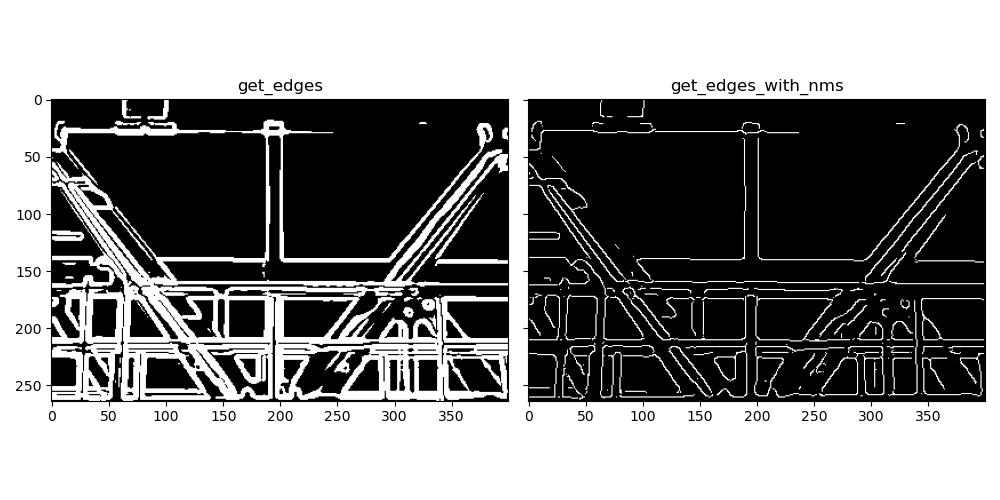

In [16]:
edges1 = get_edges(gray_im, sigma=2, theta=5)
edges2 = get_edges_with_nms(gray_im, sigma=3, theta=0.17) # 0.17 corresponds to an absolute threshold of 5

plot_multiple([edges1, edges2], ['get_edges', 'get_edges_with_nms'], imsize=5)

## Part c
The function ``get_edges`` you implemented is a simplified version of the Canny edge detection pipeline.
The main step that is still missing is the edge following with hysteresis thresholding.
The idea here is that instead of applying a single threshold over the entire image, the edge detector works with two different thresholds ``theta_high`` and ``theta_low``.
It starts with an edge pixel with a value above ``theta_high`` and then follows the contour in the direction orthogonal to the gradient until the pixel value falls below ``theta_low``.
Each pixel visited along the way is labeled as an edge.
The procedure is repeated until no further pixel above ``theta_high`` remains.

Try writing a function ``my_canny`` that implements this procedure.
Don't worry about efficiency for the moment.
You may use the provided function skeleton to help you get started but can also start from scratch. The following hints may help you:
- You can create a boolean array ``visited`` for already visited and yet-to-visit image pixels. Since we are not interested in pixels below the low threshold you can mark them as visited. In another boolean array you can flag the pixels that serve as starting points for line following.
- You can also avoid having to deal with special cases along the image borders by creating a 1-pixel boundary where the ``visited`` flag is set to ``true``.
- The actual edge following part is most easily implemented as a recursive procedure. In most cases, you will have the option to choose between several possible continuation points. Again, the easiest way is to try all of them in sequence (or even all 8 neighbors) and let the recursive procedure (together with the ``visited`` flags) do the rest.

In [10]:
def my_canny(image, sigma, theta_low, theta_high):
    # Compute gradient, apply non-maximum suppression
    ### BEGIN SOLUTION
    grad_mag, grad_dir = image_gradients_polar(image, sigma)
    grad_mag = nms_for_canny(grad_mag, grad_dir)
    ### END SOLUTION
    
    # Compute absolute threshold relative to max value
    max_val = np.max(grad_mag)
    theta_low_abs = theta_low * max_val
    theta_high_abs = theta_high * max_val
    
    # Initialize flags
    # Declare all pixels below the low threshold as visited
    # so edges are not followed there
    visited = grad_mag < theta_low_abs  
    
    # Mark boundary pixels as visited
    visited[:, 0] = 1
    visited[:, -1] = 1
    visited[0, :] = 1
    visited[-1, :] = 1
 
    # Output image
    image_out = np.zeros_like(image)
    
    def follow_edge(x, y):
        visited[y, x] = True
        image_out[y, x] = 255
        
        # Pre-define pixel index offset along different orientation
        offsets_x = [-1, -1, 0, 1, 1, 1, 0, -1]
        offsets_y = [0, -1, -1, -1, 0, 1, 1, 1]           
    
        for ox, oy in zip(offsets_x, offsets_y):
            # Note: `visited` is already False for points
            # below the low threshold.
            
            ### BEGIN SOLUTION
            if not visited[y + oy, x + ox]:
                follow_edge(x + ox, y + oy)
            ### END SOLUTION
            

    is_high = grad_mag >= theta_high_abs
    # Main loop
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            ### BEGIN SOLUTION
            if is_high[y, x] and not visited[y, x]:
                follow_edge(x, y)
            ### END SOLUTION
                
    return image_out                

OpenCV provides a built-in function that implements the Canny edge detector.
https://docs.opencv.org/3.4/da/d5c/tutorial_canny_detector.html
Try ``cv2.Canny`` on the provided example images and compare the results to those of your implementation.
Note: the implementation of ``cv2.Canny`` does not include blurring the image as we did.
So apply ``cv2.GaussianBlur`` on the image, before passing it to ``cv2.Canny``.
What do you observe?

<IPython.core.display.Javascript object>


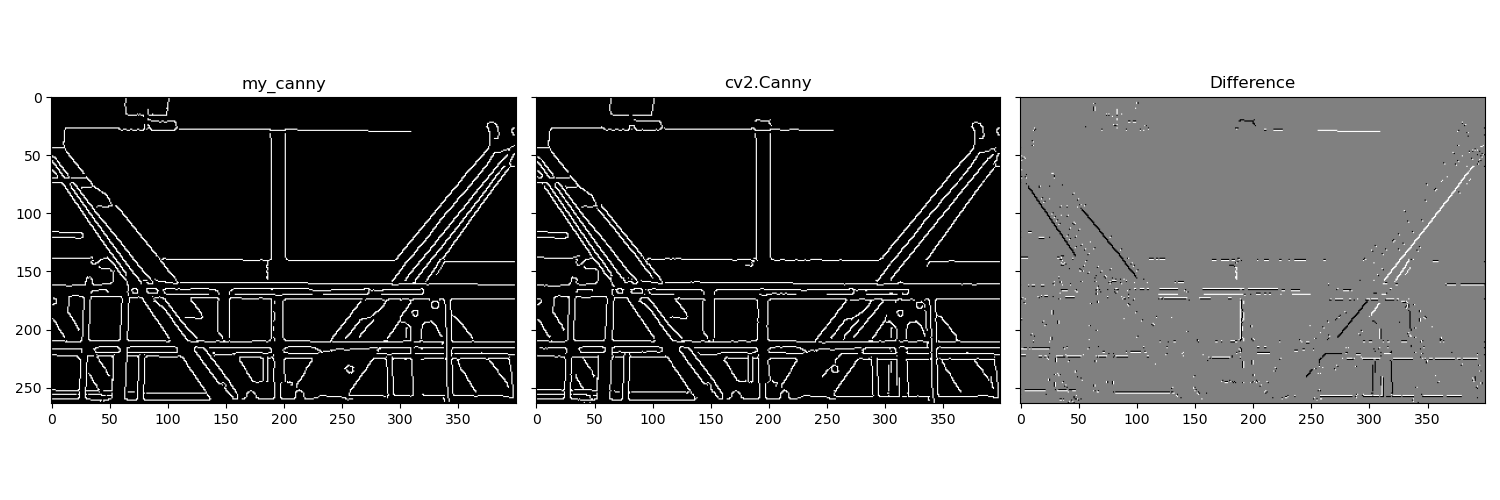

In [11]:
edge_canny = my_canny(gray_im, sigma=2, theta_low=0.1, theta_high=0.3)

blurred_cv = cv2.GaussianBlur(gray_im, ksize=(7,7), sigmaX=2)
edge_canny_cv = cv2.Canny(
    blurred_cv.astype(np.uint8), 
    39, 72, L2gradient=True).astype(np.float32)

plot_multiple([edge_canny, edge_canny_cv, edge_canny-edge_canny_cv], 
              ['my_canny', 'cv2.Canny', 'Difference'], imsize=5)

## Pard d (bonus)

This solution gives better results, but its results still depend strongly on the maximal gradient magnitude value in the image.
For a cleaner solution, we want to adapt the threshold to the distribution of all gradient magnitude values, such that we can directly control the number of edge pixels we get.
Extend the function `get_edges` by the following steps in order to do this:

- Perform non-maximum suppression on the gradient magnitude image as shown above.
- Transform the result image into a vector.
- Build a histogram of the remaining gradient magnitude values.
- Compute the cumulative sum over the histogram (except for the first cell).
- The last cell of the cumulative histogram now contains the total number of edge pixels in the image, `num_total_edge_pixels`. Compute the desired number of edge pixels `num_desired_edge_pixels` as the percentage `theta` of `num_total_edge_pixels`.
- Find the threshold for which the cumulative histogram contains the value `num_desired_edge_pixels`.